In [1]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [2]:
tf.random.set_seed(utils.SEED)

In [3]:
MEMORY_SIZE = 100_000
GAMMA = 0.995
ALPHA = 1e-3
NUM_STEPS_FOR_UPDATE = 4

In [4]:
env = gym.make('LunarLander-v2')

c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


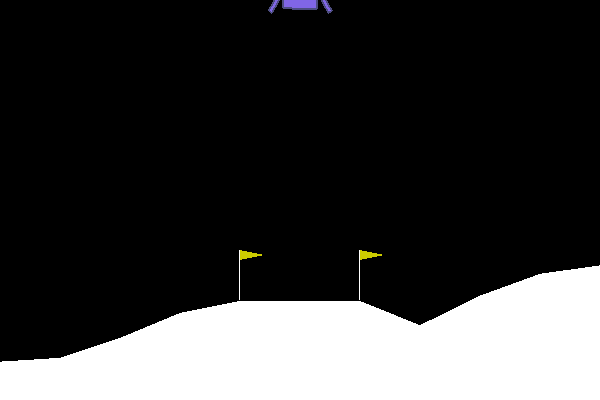

In [5]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [6]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [7]:
initial_state = env.reset()

In [8]:
action = 0

next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Info:", info)

Initial State: [0.007 1.414 0.727 0.137 -0.008 -0.165 0.000 0.000]
Action: 0
Next State: [0.014 1.417 0.726 0.112 -0.016 -0.163 0.000 0.000]
Reward Received: -0.5403685115246901
Episode Terminated: False
Info: {}


In [9]:
state_size = state_size[0]

q_network = Sequential([
    Dense(64, activation='relu', input_shape=(state_size,)),
    Dense(64, activation='relu'),
    Dense(num_actions, activation='linear')
])

target_q_network = Sequential([
    Dense(64, activation='relu', input_shape=(state_size,)),
    Dense(64, activation='relu'),
    Dense(num_actions, activation='linear')
])

optimizer = Adam(learning_rate=ALPHA)

In [10]:
from public_tests import *

test_network(q_network)
test_network(target_q_network)
test_optimizer(optimizer, ALPHA) 

All tests passed!
All tests passed!
All tests passed!


In [11]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [12]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    states, actions, rewards, next_states, done_vals = experiences
    
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]), tf.cast(actions, tf.int32)], axis=1))
        
    loss = MSE(y_targets, q_values)
    
    return loss

In [13]:
test_compute_loss(compute_loss)

All tests passed!


In [14]:
@tf.function
def agent_learn(experiences, gamma):
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    utils.update_target_network(q_network, target_q_network)

In [15]:
    start = time.time()

    num_episodes = 2000
    max_num_timesteps = 1000

    total_point_history = []

    num_p_av = 100
    epsilon = 1.0 

    memory_buffer = deque(maxlen=MEMORY_SIZE)

    target_q_network.set_weights(q_network.get_weights())

    for i in range(num_episodes):
        
        state = env.reset()
        total_points = 0
        
        for t in range(max_num_timesteps):
            
            state_qn = np.expand_dims(state, axis=0)
            q_values = q_network(state_qn)
            action = utils.get_action(q_values, epsilon)
            
            next_state, reward, done, _ = env.step(action)
            
            memory_buffer.append(experience(state, action, reward, next_state, done))
            
            update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
            
            if update:
                experiences = utils.get_experiences(memory_buffer)
                
                agent_learn(experiences, GAMMA)
            
            state = next_state.copy()
            total_points += reward
            
            if done:
                break
                
        total_point_history.append(total_points)
        av_latest_points = np.mean(total_point_history[-num_p_av:])
        
        epsilon = utils.get_new_eps(epsilon)

        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

        if (i+1) % num_p_av == 0:
            print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

        if av_latest_points >= 200.0:
            print(f"\n\nEnvironment solved in {i+1} episodes!")
            q_network.save('lunar_lander_model.h5')
            break
            
    tot_time = time.time() - start

    print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -160.14
Episode 200 | Total point average of the last 100 episodes: -105.30
Episode 300 | Total point average of the last 100 episodes: -74.812
Episode 400 | Total point average of the last 100 episodes: -3.038
Episode 500 | Total point average of the last 100 episodes: 133.42
Episode 571 | Total point average of the last 100 episodes: 201.52

Environment solved in 571 episodes!

Total Runtime: 838.28 s (13.97 min)


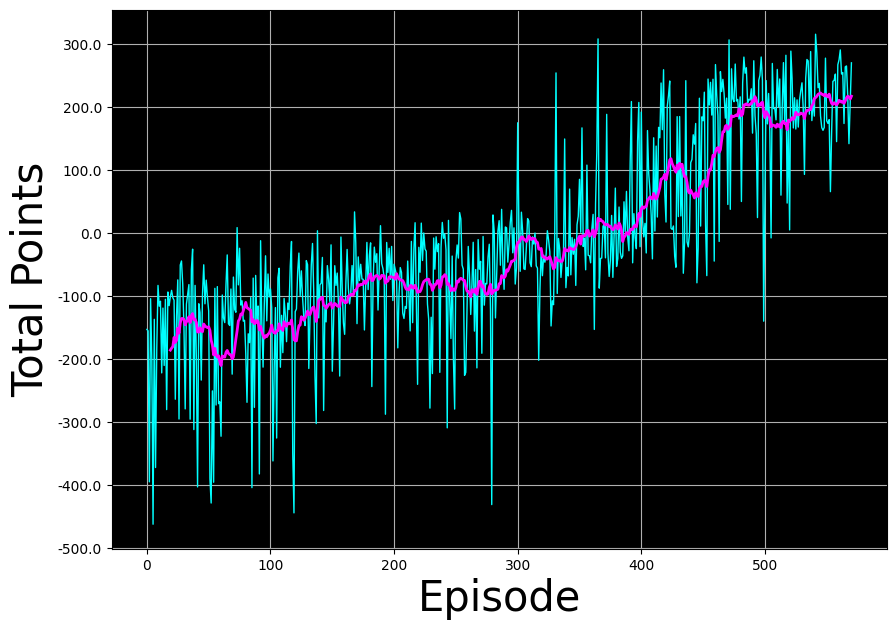

In [16]:
utils.plot_history(total_point_history)

In [17]:
import logging
logging.getLogger().setLevel(logging.ERROR)

In [18]:
filename = "./videos/lunar_lander.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)